In [6]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path

from language_structure import *
from train import batch_iter, load
from model import *

base = Path('../aclImdb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
train_df = pd.read_csv('train.csv')
train_df = train_df[train_df.file_length < 200]

In [85]:
# Sample Example from dataset
for sents, targets in batch_iter(lang, train_df, 3, shuffle=True):
    x = sents
    break

In [122]:
model_path = 'quick_test_model'
model, optim, lang, metrics = load(model_path, cpu=True)

Total Time: 5.6809 
Train Time: 4.2898


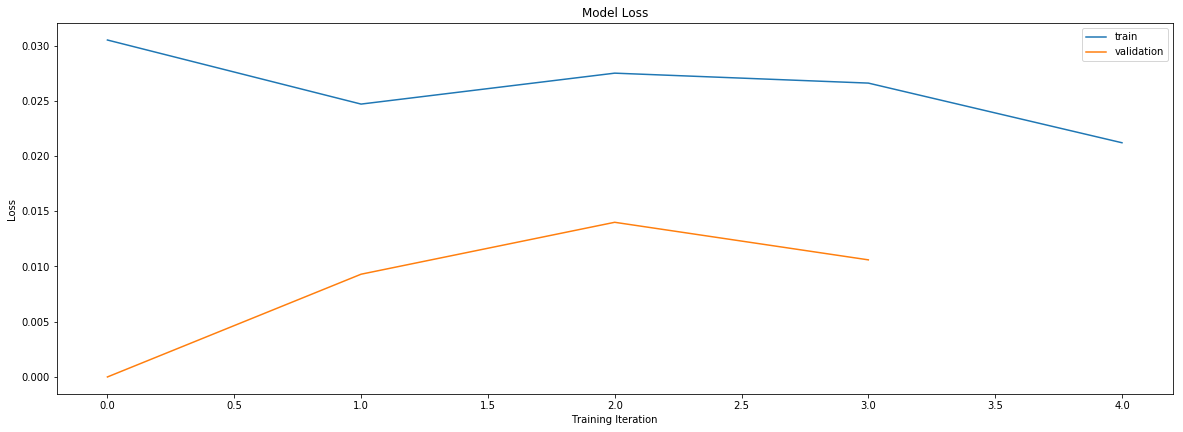

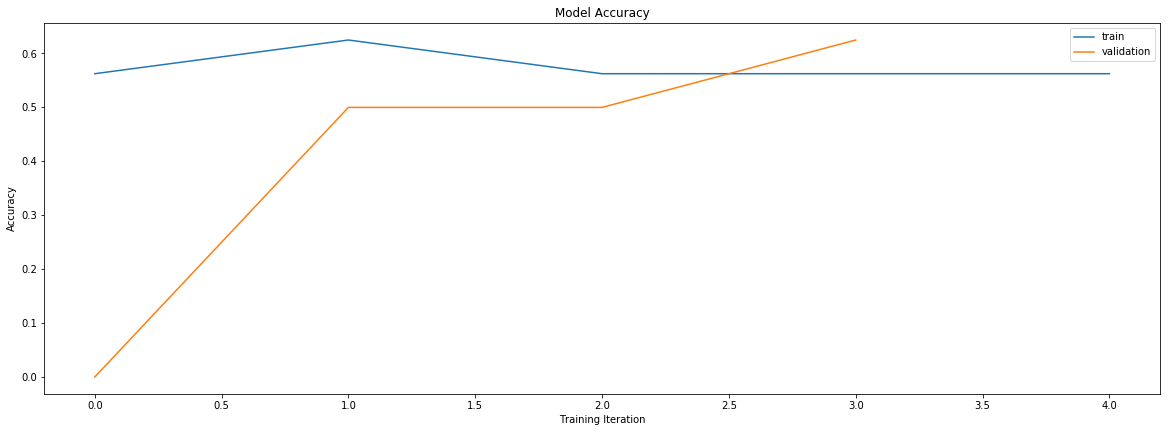

In [123]:
def plot_metrics(metrics):
    print("Total Time: {} \nTrain Time: {}".format(metrics['total_time'], metrics['train_time']))
    metrics['itr'] = list(range(len(metrics['train_loss'])))
    metrics['val_itr'] = list(range(len(metrics['val_loss'])))
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    figsize = (20, 15)
    plt.figure(1, figsize=figsize)                
    plt.subplot(211)
    plt.plot(metrics['itr'], metrics['train_loss'],  label='train')
    plt.plot(metrics['val_itr'], metrics['val_loss'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.show()
    
    # plot accuracy
    plt.figure(2, figsize=figsize)                # a second figure
    plt.subplot(212)
    plt.plot(metrics['itr'], metrics['train_acc'], label='train')
    plt.plot(metrics['val_itr'], metrics['val_acc'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    
    plt.show()
    
plot_metrics(metrics)

In [124]:
# Hook the Attention Weights
attentions = model._modules.get('attentions')
tracked_attention_weigths = []
def show(m, i, o): 
    _, w = o
    tracked_attention_weigths.append(w)
hook = attentions[0].register_forward_hook(show)
attentions

ModuleList(
  (0): MultiheadAttention(
    (out_proj): Linear(in_features=100, out_features=100, bias=True)
  )
  (1): MultiheadAttention(
    (out_proj): Linear(in_features=100, out_features=100, bias=True)
  )
)

In [125]:
h_x = model(x)
hook.remove()

In [126]:
len(tracked_attention_weigths)

1

In [127]:
w = tracked_attention_weigths[0]
w.detach().numpy().squeeze().shape

(3, 115, 115)

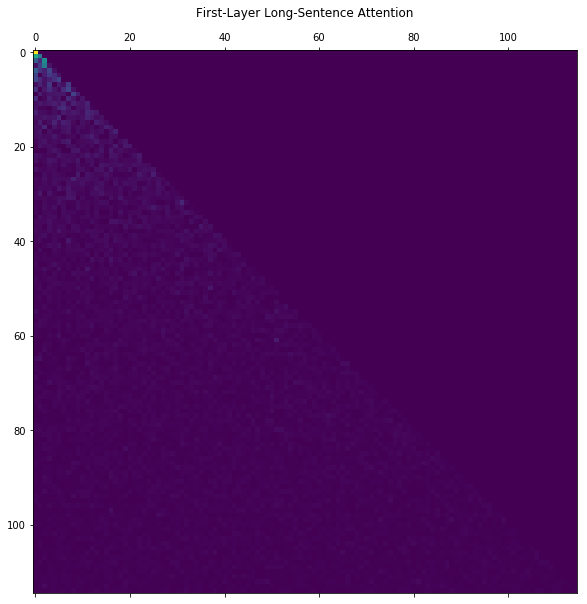

one of the worst movies i have ever seen with robert de niro the fan is a pointless cliche of an exercise in slasher flicks . it tries to spin or twist the genre with preposterous plot lines of a a crazed fan turned psychotic the movie meanders into nothing . spoiler we are to believe that a knife wielding idiot has access to and murders a baseball player in a lavish hotel with no witness security or cameras ? the movie is nonsense trying to tug at our heart strings through the hoopla of baseball ending up mockingly unsophisticated and gimmicky . not sure what all the actors were thinking when they


In [128]:
# Thanks to, 
# https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention
batch_index = 1
sentence = x[batch_index]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
attention = w.detach().numpy().squeeze()
attention = attention[batch_index] if type(batch_index) == int else attention
ax.matshow(attention, cmap='viridis')
fontdict = {'fontsize': 14}

# ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
# ax.set_yticklabels([''] + sentence, fontdict=fontdict)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_title("First-Layer Long-Sentence Attention")

plt.show()
print(' '.join(sentence))